In [1]:
using TSSM
using PyPlot
include("time_stepper.jl");

/home/hofi/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Nonlinear Schrödinger equation without potential

The soliton
$$\psi_\mathrm{ex}(x,t)=\frac{a\mathrm{e}^{\frac{1}{2}\mathrm{i}((a^2-b^2)t-bx)}}{\cosh(a(bt+x-c))}$$ 
is the exact solution of the cubic nonlinear Schrödinger
$$\mathrm{i}\frac{\partial}{\partial t}\psi(x,t)=-\frac{1}{2}\Delta\psi(x,t)+\kappa|\psi(x,t)|^2\psi(x,t),
\quad \psi(x,0) = \psi_\mathrm{ex}(x,0),$$
where $\kappa=-1$, and $a,b,c\in\mathbb{R}$ are arbitrarily chosen parameters. 

In [2]:
const a = 2
const b = 1
const c = 0
function soliton(x, t)
    h = (a^2 - b^2)/2*t - b*x
    (a./cosh(a*(b*t+x-c))).*exp(1im*h) 
end    

soliton (generic function with 1 method)

We use a Fourier spectral method on the computational domain  $[x_\mathrm{min},x_\mathrm{max}]=[-16,16]$ with $n_x=2048$ discretization points:

In [3]:
nx = 2048
xmin = -16
xmax = +16
method = Schroedinger1D(nx, xmin, xmax, cubic_coupling=-1)

TSSM.Schroedinger1D{Float64}(Ptr{Void} @0x00000000053f7750)

We integrate from $t_0=0$ to $t_\mathrm{end}=1$ with initial data $\psi_\mathrm{ex}(x,t_0)$. As reference solution to be compared with the numerical solution at $t=t_\mathrm{end}$ we use the exact solution $\psi_\mathrm{ex}(x,t_\mathrm{end})$:

In [4]:
t0 = 0
tend = 1
psi = wave_function(method)
psi_ref = wave_function(method)
set!(psi, soliton, t0)        # initial data at t=t0
set!(psi_ref, soliton, tend)  # reference solution at t=tend

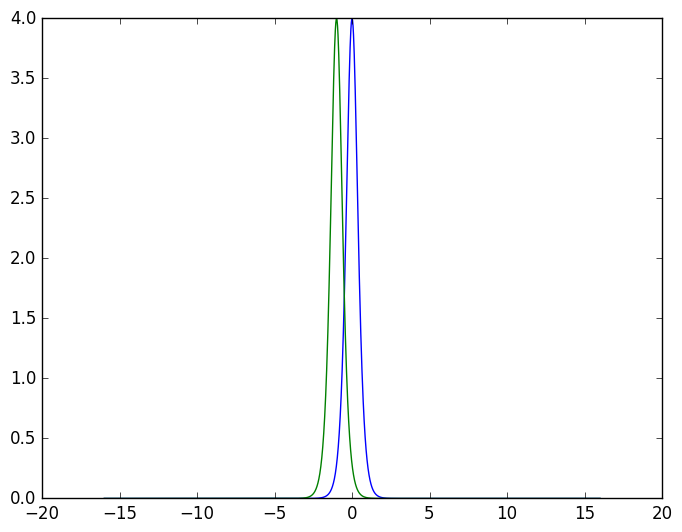

In [5]:
plot(get_nodes(method), abs(get_data(psi)).^2)
hold(true)
plot(get_nodes(method), abs(get_data(psi_ref)).^2)
hold(false)

Global error at $t=t_\mathrm{end}$ for Strang splitting:

In [6]:
global_orders(psi, psi_ref, t0, tend, tend-t0, scheme=Strang, rows=12) 
; 

             dt         err      p
-----------------------------------
  1   1.000e+00   1.586e+00
  2   5.000e-01   9.603e-01   0.72
  3   2.500e-01   4.448e-01   1.11
  4   1.250e-01   1.502e-01   1.57
  5   6.250e-02   4.157e-02   1.85
  6   3.125e-02   1.071e-02   1.96
  7   1.563e-02   2.698e-03   1.99
  8   7.813e-03   6.758e-04   2.00
  9   3.906e-03   1.690e-04   2.00
 10   1.953e-03   4.226e-05   2.00
 11   9.766e-04   1.057e-05   2.00
 12   4.883e-04   2.642e-06   2.00


Next we use a scheme of order 5 (method "PP 5/6 A" from http://www.asc.tuwien.ac.at/~winfried/splitting):


In [7]:
scheme_5 = ( 0.201651044312324230,   0.578800656272664932, 
             0.562615975356569200,   0.273128836056524479, 
             0.253874038247554845,  -0.102733803148432142, 
            -0.835351693190370636,   0.068014946093165092, 
             0.068014946093165092,  -0.835351693190370636,
            -0.102733803148432142,   0.253874038247554845, 
             0.273128836056524479,   0.562615975356569200, 
             0.578800656272664932,   0.201651044312324230 )          
global_orders(psi, psi_ref, t0, tend, tend-t0, scheme=scheme_5, rows=10) 
;

             dt         err      p
-----------------------------------
  1   1.000e+00   2.041e+00
  2   5.000e-01   5.641e-01   1.85
  3   2.500e-01   8.913e-02   2.66
  4   1.250e-01   7.838e-03   3.51
  5   6.250e-02   3.703e-04   4.40
  6   3.125e-02   5.960e-06   5.96
  7   1.563e-02   5.499e-08   6.76
  8   7.813e-03   1.083e-09   5.67
  9   3.906e-03   2.676e-11   5.34
 10   1.953e-03   1.163e-12   4.52


## Linear Schrödinger equation with time dependent potential

The exact solution of the *linear* Schrödinger equation
$$\mathrm{i}\frac{\partial}{\partial t}\psi(x,t)=-\frac{1}{2}\Delta\psi(x,t)+V(x,t)\psi(x,t),
\quad \psi(x,0) = \psi_\mathrm{ex}(x,0),$$
with time dependent potential
$$V(x,t)=\kappa|\psi_\mathrm{ex}(x,t)|^2$$
is by construction $\psi_\mathrm{ex}(x,t)$ form above.

In [8]:
V(x,t) = -1*abs(soliton(x,t)).^2
method = Schroedinger1D(nx, xmin, xmax, potential_t=V)
psi = wave_function(method)
psi_ref = wave_function(method)
set!(psi, soliton, t0)        # initial data at t=t0
set!(psi_ref, soliton, tend)  # reference solution at t=tend

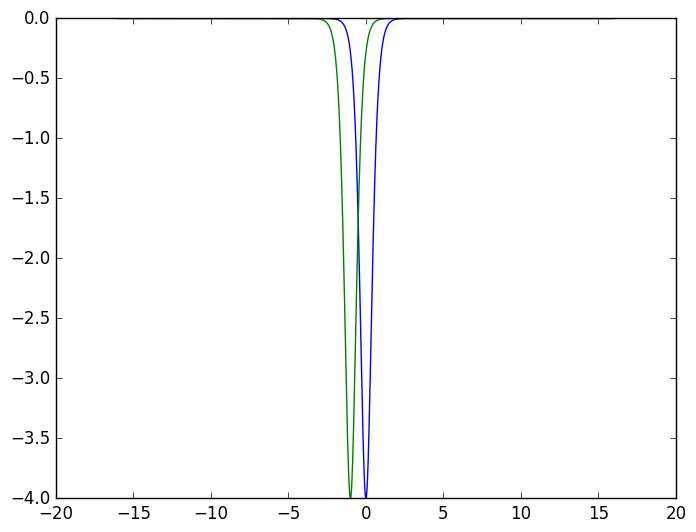

In [9]:
plot(get_nodes(method), get_potential_t(method, 0))
hold(true)
plot(get_nodes(method), get_potential_t(method, 1))
hold(false)

We use an ABC scheme of order 3 (method "PP 3/4 A 3" from http://www.asc.tuwien.ac.at/~winfried/splitting) where
the C operator propagates time:

In [10]:
#ABC scheme PP 3/4 A 3 
scheme_3 = (  0.461601939364879971, -0.266589223588183997,  -0.360420727960349671,
             -0.0678710530507800801, 0.0924576733143338354,  0.579154058410941403,
             -0.0958868852260720250, 0.674131550273850162,   0.483422668461380403,
              0.483422668461380403,  0.674131550273850162,  -0.0958868852260720250,
              0.579154058410941403,  0.0924576733143338354, -0.0678710530507800801,
             -0.360420727960349671, -0.266589223588183997,   0.461601939364879971 )
global_orders(psi, psi_ref, t0, tend, tend-t0, scheme=scheme_3, rows=10, 
              operator_sequence="ABT") 
;

             dt         err      p
-----------------------------------
  1   1.000e+00   1.341e+00
  2   5.000e-01   4.789e-01   1.49
  3   2.500e-01   9.634e-02   2.31
  4   1.250e-01   1.148e-02   3.07
  5   6.250e-02   1.110e-03   3.37
  6   3.125e-02   1.249e-04   3.15
  7   1.563e-02   1.552e-05   3.01
  8   7.813e-03   1.938e-06   3.00
  9   3.906e-03   2.421e-07   3.00
 10   1.953e-03   3.027e-08   3.00


In [11]:
global_orders(psi, psi_ref, t0, tend, tend-t0, scheme=scheme_3, rows=10, 
              operator_sequence="ATB") 
;

             dt         err      p
-----------------------------------
  1   1.000e+00   1.128e+00
  2   5.000e-01   5.461e-01   1.05
  3   2.500e-01   1.794e-01   1.61
  4   1.250e-01   3.064e-02   2.55
  5   6.250e-02   2.031e-03   3.91
  6   3.125e-02   5.079e-05   5.32
  7   1.563e-02   3.790e-06   3.74
  8   7.813e-03   4.429e-07   3.10
  9   3.906e-03   5.441e-08   3.03
 10   1.953e-03   6.771e-09   3.01


## Nonlinear Schrödinger equation with time dependent potential

The exact solution of the *nonlinear* Schrödinger equation
$$\mathrm{i}\frac{\partial}{\partial t}\psi(x,t)=-\frac{1}{2}\Delta\psi(x,t)+V_\alpha(x,t)\psi(x,t)+\alpha\kappa|\psi_\mathrm{ex}(x,t)|^2\psi(x,t),\quad\psi(x,0) = \psi_\mathrm{ex}(x,0),$$
with time dependent potential
$$V_\alpha(x,t)= (1-\alpha)\kappa|\psi_\mathrm{ex}(x,t)|^2$$
and, e.g., $\alpha=\frac{1}{2}$ is again given by $\psi_\mathrm{ex}(x,t)$ form above.

In [12]:
V1(x,t) = -0.5*abs(soliton(x,t)).^2
method = Schroedinger1D(nx, xmin, xmax, potential_t=V1, cubic_coupling=-0.5)
psi = wave_function(method)
psi_ref = wave_function(method)
set!(psi, soliton, t0)        # initial data at t=t0
set!(psi_ref, soliton, tend)  # reference solution at t=tend

In [13]:
global_orders(psi, psi_ref, t0, tend, tend-t0, scheme=scheme_3, rows=10,
              operator_sequence="ABT") 
;

             dt         err      p
-----------------------------------
  1   1.000e+00   1.128e+00
  2   5.000e-01   4.499e-01   1.33
  3   2.500e-01   9.886e-02   2.19
  4   1.250e-01   1.328e-02   2.90
  5   6.250e-02   1.170e-03   3.50
  6   3.125e-02   1.169e-04   3.32
  7   1.563e-02   1.437e-05   3.02
  8   7.813e-03   1.793e-06   3.00
  9   3.906e-03   2.241e-07   3.00
 10   1.953e-03   2.803e-08   3.00
